# Transformer Example 

In [1]:
import pandas as pd 
import numpy as np 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set()

## Resourcs

* https://trungtran.io/2019/04/29/create-the-transformer-with-tensorflow-2-0/
* https://keras.io/examples/nlp/text_classification_with_transformer/
* https://kazemnejad.com/blog/transformer_architecture_positional_encoding/
* https://arxiv.org/abs/1706.03762
* https://www.tensorflow.org/text/tutorials/transformer
* https://www.youtube.com/watch?v=dichIcUZfOw


## Transformer

![transformer](https://miro.medium.com/max/2880/1*BHzGVskWGS_3jEcYYi6miQ.png)

![multihead](https://miro.medium.com/max/4548/1*ETe4WrKJ1lS1MKDgBPIM0g.png)

In [2]:
class TransformerBlock(layers.Layer):
    def __init__(self, key_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(key_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs):
        attn_output = self.att(inputs,inputs)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

## Positional encoding
$$
PE_{(pos,2i)} = \sin (pos/10000^{2i/d_{model}})
$$

$$
PE_{(pos,2i+1)} = \cos (pos/10000^{2i/d_{model}})
$$

In [3]:
class PositionEmbedding(layers.Layer):
    def __init__(self,n,d):
        super(PositionEmbedding, self).__init__()
        self.n, self.d = n, d
        self.pos_encoding = self.positional_encoding(n,d)
        
    def get_angles(self,pos, i, d_model):
        angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
        return pos * angle_rates
    
    def positional_encoding(self,position, d_model):
        angle_rads = self.get_angles(np.arange(position)[:, np.newaxis],
                              np.arange(d_model)[np.newaxis, :],
                              d_model)

        # apply sin to even indices in the array; 2i
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

        # apply cos to odd indices in the array; 2i+1
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

        pos_encoding = angle_rads[np.newaxis, ...]

        return tf.cast(pos_encoding, dtype=tf.float32)
    
    def call(self, x):
        x += self.pos_encoding[:, :self.n, :]
        return x 

In [4]:
def getModel(input_shape=(50)):
    inputs = tf.keras.Input(input_shape)
    
    pos_embed = PositionEmbedding(10,5)
    transformer = TransformerBlock(5,10,10)
    
    # reshape seq of len 50 into 10 seq of len 5 each
    x = tf.keras.layers.Reshape((10,5))(inputs)
    x = pos_embed(x)
    x = transformer(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.1)(x)
    yh = layers.Dense(1, activation="linear")(x)
    model = tf.keras.Model(inputs,yh)
    print(model.summary())
    return model

## Demo 

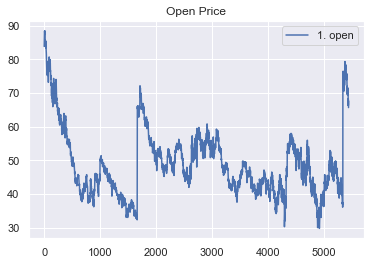

In [5]:
df = pd.read_csv('stock_data.csv')
df['1. open'].plot(title='Open Price')
plt.legend()

In [6]:
N_TEST = 100
BATCH_SIZE = 12
N_INPUT = 50

train_series = df['1. open'].iloc[:].values
test_series = df['1. open'].iloc[N_TEST:].values

train_generator = TimeseriesGenerator(train_series, train_series, length=N_INPUT , batch_size=BATCH_SIZE)
test_generator = TimeseriesGenerator(test_series, test_series, length=N_INPUT , batch_size=BATCH_SIZE)

In [7]:
model = getModel()
opt = tf.keras.optimizers.Adam(learning_rate = 1e-3)
model.compile(optimizer=opt,loss=tf.keras.losses.MeanSquaredError(),metrics=['MSE'])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
reshape (Reshape)            (None, 10, 5)             0         
_________________________________________________________________
position_embedding (Position (None, 10, 5)             0         
_________________________________________________________________
transformer_block (Transform (None, 10, 5)             1290      
_________________________________________________________________
global_average_pooling1d (Gl (None, 5)                 0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6     

In [8]:
history = model.fit(train_generator, steps_per_epoch=len(train_generator),epochs=100)

Epoch 1/100
449/449 [==============================] - 2s 2ms/step - loss: 1965.8839 - MSE: 1965.8839
Epoch 2/100
449/449 [==============================] - 1s 2ms/step - loss: 1268.1438 - MSE: 1268.1438
Epoch 3/100
449/449 [==============================] - 1s 2ms/step - loss: 587.0464 - MSE: 587.0464
Epoch 4/100
449/449 [==============================] - 1s 2ms/step - loss: 242.6558 - MSE: 242.6558
Epoch 5/100
449/449 [==============================] - 1s 2ms/step - loss: 153.2721 - MSE: 153.2721
Epoch 6/100
449/449 [==============================] - 1s 2ms/step - loss: 142.9143 - MSE: 142.9143
Epoch 7/100
449/449 [==============================] - 1s 2ms/step - loss: 138.9700 - MSE: 138.9700
Epoch 8/100
449/449 [==============================] - 1s 2ms/step - loss: 138.3191 - MSE: 138.3191
Epoch 9/100
449/449 [==============================] - 1s 2ms/step - loss: 140.1749 - MSE: 140.1749
Epoch 10/100
449/449 [==============================] - 1s 2ms/step - loss: 137.0968 - MSE: 137.

449/449 [==============================] - 1s 2ms/step - loss: 49.6931 - MSE: 49.6931
Epoch 84/100
449/449 [==============================] - 1s 2ms/step - loss: 49.3352 - MSE: 49.3352
Epoch 85/100
449/449 [==============================] - 1s 2ms/step - loss: 48.2296 - MSE: 48.2296
Epoch 86/100
449/449 [==============================] - 1s 2ms/step - loss: 49.9778 - MSE: 49.9778
Epoch 87/100
449/449 [==============================] - 1s 2ms/step - loss: 51.1084 - MSE: 51.1084
Epoch 88/100
449/449 [==============================] - 1s 2ms/step - loss: 49.7612 - MSE: 49.7612
Epoch 89/100
449/449 [==============================] - 1s 2ms/step - loss: 50.4319 - MSE: 50.4319
Epoch 90/100
449/449 [==============================] - 1s 2ms/step - loss: 45.9537 - MSE: 45.9537
Epoch 91/100
449/449 [==============================] - 1s 2ms/step - loss: 48.3076 - MSE: 48.3076
Epoch 92/100
449/449 [==============================] - 1s 2ms/step - loss: 43.0625 - MSE: 43.0625
Epoch 93/100
449/449 [=

In [9]:
yh = model.predict(test_generator)

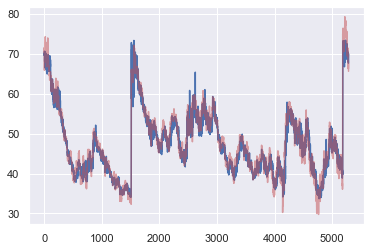

In [10]:
plt.plot(range(0,yh.shape[0]),yh.flatten())
plt.plot(range(0,yh.shape[0]),test_series.flatten()[test_series.shape[0]-yh.shape[0]:],color='r',alpha=.5)